# Neuron attribution

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [3]:
# Select the best device to use

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [4]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

def train_model(model, optimizer, loss_fn):
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [5]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

og_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=og_model.parameters(), lr=0.1)

In [6]:
train_model(og_model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35563 | Test loss: 0.14953, Test acc: 95.40%


In [7]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in og_model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

X = train.data.reshape((60000, 784)).detach().numpy()
T = train.targets.detach().numpy()

# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

nb_digits = len(train.classes)

## 2. Attribution

In [8]:
attributions = []
for l in range(L+1):
    means = [np.mean(A[l][T==digit], axis=0) for digit in range(10)]
    means = np.array(means).T
    means = [np.argmax(m) for m in means]

    attributions.append(means)

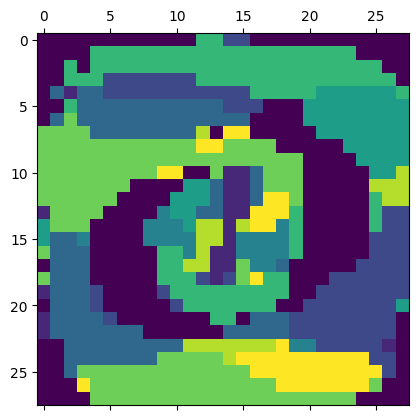

[]

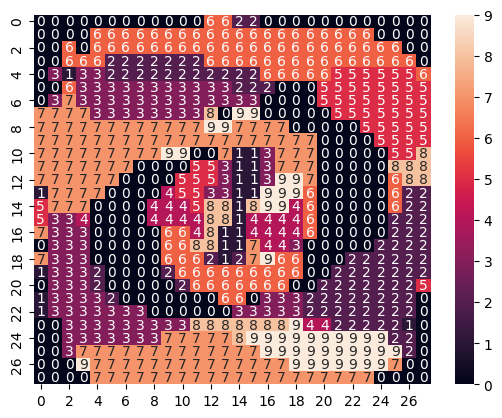

In [9]:
plt.matshow(np.array(attributions[0]).reshape(28, 28))
plt.show()

df_cm = pd.DataFrame(np.array(attributions[0]).reshape(28, 28))
sn.heatmap(df_cm, annot=True)
plt.plot()

49.260724698042495
11.266666666666666
15.200000000000001
0.0


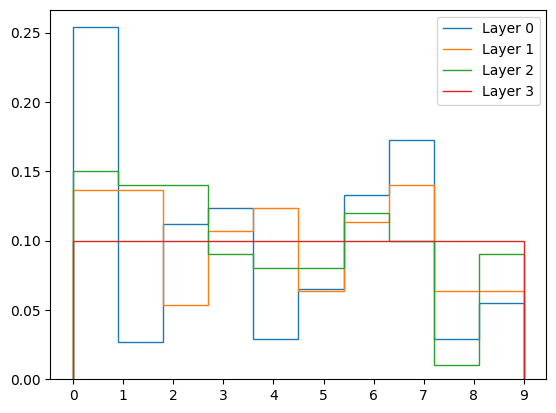

In [17]:
for i, a in enumerate(attributions):
    counts, bins = np.histogram(a)
    print(np.var(counts/sum(counts))*10e3)
    plt.stairs(counts/sum(counts), bins, label=f"Layer {i}")
plt.legend()
plt.xticks(list(range(10)))
plt.show()

In [27]:
connections = []

for l in range(L):
    connections.append([[0 for _ in range(10)] for _ in range(10)])
    for i, neuron in enumerate(W[l]):
        strongest = np.argmax(np.abs(neuron))
        orig = attributions[l][i]
        dest = attributions[l][strongest]
        connections[l][orig][dest] += 1


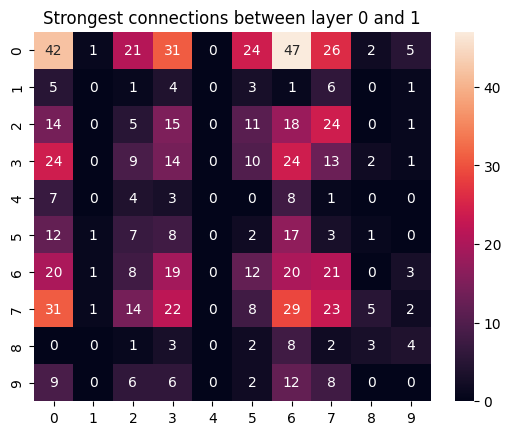

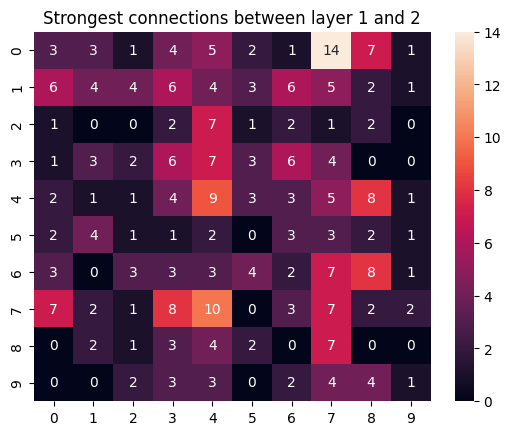

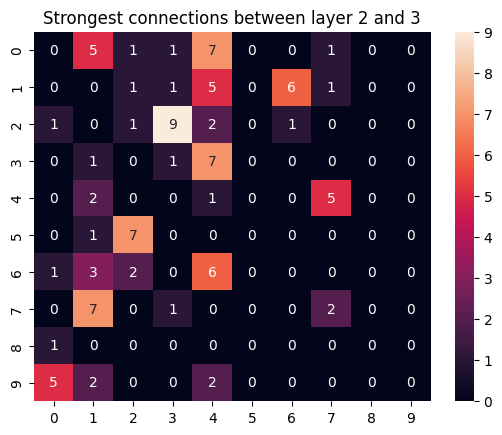

In [28]:
for l in range(L):
    df_cm = pd.DataFrame(connections[l], range(10), range(10))
    sn.heatmap(df_cm, annot=True)
    plt.title(f"Strongest connections between layer {l} and {l+1}")
    plt.show()

In [11]:
confusion = [[0 for _ in range(10)] for _ in range(10)]

for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    test_pred = og_model(X).argmax(dim=1)

    for i in range(len(y)):
        confusion[y[i]][test_pred[i]] += 1

[]

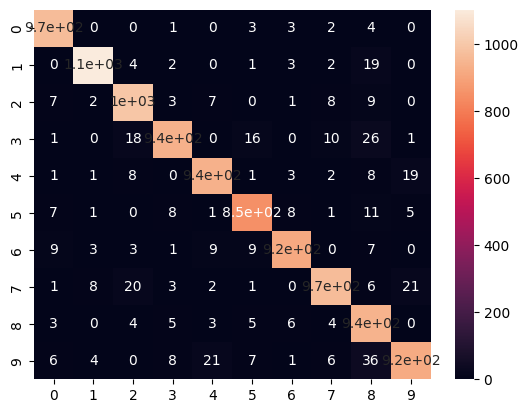

In [12]:
df_cm = pd.DataFrame(confusion, range(10), range(10))
sn.heatmap(df_cm, annot=True)
plt.plot()